In [5]:
# %load voronoicells.py
#/* -.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.
#
# File Name : voronoicells.py
#
# Purpose :
#
# Creation Date : 22-10-2019
#
# Last Modified : Tue Oct 22 16:40:08 2019
#
# Created By : Hongjian Fang: hfang@mit.edu 
#
#_._._._._._._._._._._._._._._._._._._._._.*/


def voronoicells(latmin=0,latmax=10,lonmin=0,lonmax=10,\
        depmin=0,depmax=30, ncell = 300):

    pos = np.zeros((ncell,3))
    #print(iset)
    phi = np.random.rand(ncell,)*(latmax-latmin)+latmin
    phi = np.pi/2-np.deg2rad(phi)
    theta = np.random.rand(ncell,)*(lonmax-lonmin)+lonmin
    theta = np.deg2rad(theta)
    rad = 6371.0-depmax+np.random.rand(ncell,)*(depmax-depmin)

    xpts = rad*np.sin(phi)*np.cos(theta)
    ypts = rad*np.sin(phi)*np.sin(theta)
    zpts = rad*np.cos(phi)
    pos[:,0] = xpts
    pos[:,1] = ypts 
    pos[:,2] = zpts 
    tri = Delaunay(pos)
    neiList=defaultdict(list)
    for p in tri.vertices:
        for i,j in itertools.combinations(p,2):
            neiList[i+1].append(j+1)
            neiList[j+1].append(i+1)
    for p in range(1,1+len(pos)):
        neiList[0].append(p)
    neiList[0] = np.unique(neiList[0])
    for p in range(1,len(pos)+1):
        neiList[p].append(p)
        neiList[p] = np.unique(neiList[p])
    return pos,neiList


In [6]:
# %load PyVoroTomo.py
#/* -.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.
#
# File Name : PyVoroTomo.py
#
# Purpose : Random projections based seismic tomography using PyKonal
#
# Creation Date : 22-10-2019
#
# Last Modified : Tue Oct 22 16:40:23 2019
#
# Created By : Hongjian Fang: hfang@mit.edu 
#
#_._._._._._._._._._._._._._._._._._._._._.*/

import yaml
from collections import defaultdict
import itertools
from scipy.spatial import Delaunay
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import lsmr
# from voronoicells import voronoicells
import sys
import pandas as pd
import numpy as np
import scipy.spatial
from matplotlib import pyplot as plt

# read input file
# if len(sys.argv) == 1:
parafile = 'PyVoroTomo.in'
# else:
#     parafile = str(sys.argv[1])

with open(parafile,'r') as fin:
    par = yaml.load(fin,Loader=yaml.FullLoader)

#hvratio = par['hvratio']
latmin = par['latmin']
nlat = par['nlat']
dlat = par['dlat']
lonmin = par['lonmin']
nlon = par['nlon']
dlon = par['dlon']
depmin = par['radmin']
nrad = par['nrad']
drad = par['drad']
damp = par['damp']
datafile = par['datafile']
ncell = par['ncell']
nsets = par['nsets']

# inversion
## constructing projection matrix
latmax = latmin+nlat*dlat
lonmax = lonmin+nlon*dlon
depmax = depmin+nrad*drad


In [181]:
def findrayidx(ray):
    '''
    ...vectorized version of finding ray index...
    '''
    idxt = 1
    colid = []
    ray['x'] = ray['rho'] * np.sin(ray['theta']) * np.cos(ray['phi'])
    ray['y'] = ray['rho'] * np.sin(ray['theta']) * np.sin(ray['phi'])
    ray['z'] = ray['rho'] * np.cos(ray['theta'])
    dist = scipy.spatial.distance.cdist(ray[['x', 'y', 'z']].values, cellpos)
    argmin = np.argmin(dist, axis=1)
    ray['cellidx'] = argmin
    return (ray)

In [175]:
%timeit cellpos,nearcells,Gp = outputproj()

14.5 s ± 142 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [183]:
%timeit cellpos,nearcells,Gp = outputproj_2()

2.32 s ± 81.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [182]:
def outputproj():
    '''
    vectorized version of generating projecting matrix
    '''
#     hvratio = 1.0
    cellpos, nearcells = voronoicells(latmin=latmin,latmax=latmax,lonmin=lonmin,\
            lonmax=lonmax, depmin=depmin,depmax=depmax, ncell = ncell)
    mdim = (nlat+1)*(nlon+1)*(nrad+1)
    latgrid = np.linspace(latmin,latmax,nlat+1)
    longrid = np.linspace(lonmin,lonmax,nlon+1)
    depgrid = np.linspace(depmin,depmax,nrad+1)

    latgrid = np.pi/2-np.deg2rad(latgrid)
    longrid = np.deg2rad(longrid)
    depgrid = 6371.0-depgrid
    
    longrids,depgrids,latgrids = np.meshgrid(longrid,depgrid,latgrid)
    
    xpts = depgrids.flatten()*np.sin(latgrids.flatten())*np.cos(longrids.flatten())
    ypts = depgrids.flatten()*np.sin(latgrids.flatten())*np.sin(longrids.flatten())
    zpts = depgrids.flatten()*np.cos(latgrids.flatten())
    
    dist = scipy.spatial.distance.cdist(np.vstack([xpts,ypts,zpts]).T, cellpos)
    colid = np.argmin(dist, axis=1)
    rowid = np.arange(mdim)
    
    Gp = coo_matrix((np.ones(mdim,),(rowid,colid)),shape=(mdim,ncell))
    return cellpos,nearcells,Gp


In [14]:
# # read data
datafile = 'testpykonal.h5'
data = pd.HDFStore(datafile)
srcs = data['origin']
arrs = data['arr']
rcs = data['stations']

# # selecting subsets of data
# ## come back here later for selecting based on spatial locations, i.e. downweight those inside event or station clusters
arrs = arrs[arrs['phase']=='P']
src_sub = srcs.sample(n=1000)
# src_sub = srcs
arrs_sub = arrs[arrs['event_id'].isin(src_sub['event_id'])].reset_index()

In [15]:
# constructing initial velocity model
df0 = pd.DataFrame()
latgrid = np.linspace(latmax,latmin,nlat+1)
longrid = np.linspace(lonmin,lonmax,nlon+1)
depgrid = np.linspace(depmax,depmin,nrad+1)
lon1,lat1 = np.meshgrid(longrid,latgrid)

for idep in range(nrad+1):
    vs = 6.0*np.ones((nlat+1)*(nlon+1),)
    df = pd.DataFrame(vs,columns=('vs',))
    df['theta'] = np.pi/2-np.deg2rad(lat1.flatten())
    df['phi'] = np.deg2rad(lon1.flatten())
    df['rho'] = 6371-depgrid[idep]
    df0 = df0.append(df, ignore_index=True)

nrho, ntheta, nphi = len(df0['rho'].unique()), len(df0['theta'].unique()), len(df0['phi'].unique())
drho               = np.mean(np.diff(df0['rho'].unique()))
dtheta             = np.mean(np.diff(df0['theta'].unique()))
dphi               = np.mean(np.diff(df0['phi'].unique()))
rho0               = df0['rho'].min()
theta0             = df0['theta'].min()
phi0               = df0['phi'].min()
vel = df0['vs'].values.reshape((nrho, ntheta, nphi))

np.savez_compressed(
    'socalini.npz',
    vel=vel,
    min_coords=np.array([rho0, theta0, phi0]),
    node_intervals=np.array([drho, dtheta, dphi]),
    npts=np.array([nrho, ntheta, nphi])
)

In [16]:
import pykonal

npz = np.load('socalini.npz')
def init_farfield():
    far_field                      = pykonal.EikonalSolver(coord_sys='spherical')
    far_field.vgrid.min_coords     = npz['min_coords']
    far_field.vgrid.node_intervals = npz['node_intervals']
    far_field.vgrid.npts           = npz['npts']
    far_field.vv                   = npz['vel']
    return (far_field)

In [17]:
dfs = arrs_sub.merge(
    srcs,
    on='event_id',
    suffixes=('_arrival','_origin')
).merge(
    rcs,
    on=('net','sta'),
    suffixes=('_evt','_sta')
)
dfs['travel_time'] = dfs['time_arrival'] - dfs['time_origin']
dfs['travel_time'] = dfs['travel_time'].dt.total_seconds()
## decide whether to treat receivers as sources. Prefered if nrc << nsrc
dfs['station_id'] = dfs['net'].astype(str)+'_'+dfs['sta'].astype(str)

In [18]:
def geo2sph(lat, lon,depth):
    return(
        6371 - depth,
        np.pi/2 - np.radians(lat),
        np.radians(lon)
    )

In [124]:
velall = np.zeros((nrad+1)*(nlon+1)*(nlat+1),)
for iset in range(nsets):
    print('iset'+str(iset),end='\r')
    cellpos, nearcells, Gp = outputproj()
    dfssub = dfs.sample(n=4000)
#     dfssub = dfssub.set_index('station_id')
    rcs = dfssub.index.unique()
    syndata = []
    colidp = []
    rowidp = []
    nonzerop = []
    dobs = []
    ridx = 0
    for irc in rcs:
#         print(ridx,len(rcs),irc,end='\r')
#         arr4rc = dfssub.loc[irc]
        arr4rc = dfssub[dfssub.index.values==irc]
        lat0 = arr4rc['lat_sta'].iloc[0]
        lon0 = arr4rc['lon_sta'].iloc[0]
        depth0 = arr4rc['elev'].iloc[0]
        rho0   = 6371. - depth0
        theta0 = np.pi/2 - np.radians(lat0)
        phi0   = np.radians(lon0)

        far_field = init_farfield()
        # near_field should depend on different srcs, pay attention to the boudaries
        near_field                      = pykonal.EikonalSolver(coord_sys='spherical')
        # near_field.vgrid.min_coords     = npz['node_intervals'][0] / 5, 0, 0
        near_interv = npz['node_intervals'] / 5
    #     near_field.vgrid.min_coords     = rho0-5*near_interv[0], theta0-5*near_interv[1], phi0-5*near_interv[2]
        near_field.vgrid.min_coords     = near_interv[0], 0, 0
        near_field.vgrid.node_intervals = near_interv[0], np.pi/20, np.pi/20
        near_field.vgrid.npts           = 50, 21, 40

        # don't quite understand here...
        near_field.transfer_velocity_from(far_field, (rho0, theta0, phi0))
        vvi = pykonal.LinearInterpolator3D(near_field.vgrid, near_field.vv)

        for it in range(near_field.pgrid.npts[1]):
            for ip in range(near_field.pgrid.npts[2]):
                idx = (0, it, ip)
                near_field.uu[idx]     = near_field.pgrid[idx + (0,)] / vvi(near_field.pgrid[idx])
                near_field.is_far[idx] = False
                near_field.close.push(*idx)

        near_field.solve()
        far_field.transfer_travel_times_from(near_field, (-rho0, theta0, phi0), set_alive=True)
    #     break
        far_field.solve()
        uui = lambda lat, lon, depth: \
        pykonal.LinearInterpolator3D(far_field.pgrid, far_field.uu)(geo2sph(lat, lon,depth))

        for isrc in range(len(arr4rc)):
    #         print(isrc)
            try:
                syndata = uui(arr4rc['lat_evt'].iloc[isrc],arr4rc['lon_evt'].iloc[isrc],arr4rc['depth'].iloc[isrc])
                src_pos = geo2sph(arr4rc['lat_evt'].iloc[isrc],arr4rc['lon_evt'].iloc[isrc],arr4rc['depth'].iloc[isrc])
                ray = far_field.trace_ray(src_pos)
                ray = pd.DataFrame(ray,columns=('rho','theta','phi'))
                ray = findrayidx(ray)
                ray = ray.groupby('cellidx').count()
                dres = arr4rc['travel_time'].iloc[isrc]-syndata
                if abs(dres)>3.0:
                    continue
                dobs.append(dres)
                for iseg in range(len(ray)):
                    colidp.append(ray.index.values[iseg])
                    rowidp.append(ridx)
                    nonzerop.append(far_field._get_step_size()*ray['rho'].iloc[iseg])
                
                ridx += 1
            except Exception as err:
                print('ERROR', err)
                syndata = np.nan
    #     break

    G = coo_matrix((nonzerop,(rowidp,colidp)),shape=(ridx,ncell))

    atol = 1e-3
    btol = 1e-4
    maxiter = 100
    conlim = 50
    damp = 1.0

    x = lsmr(G,dobs,damp,atol,btol,conlim,maxiter,show=False)
    x = x[0]
    vel = Gp*x
    velall += vel



ERROR Ray went out of bounds: (6374.028214719725, 0.9798822012738883, -2.0284915459598376)


In [125]:


# output velocity model and locaitons
vel3d = velall.reshape(nrad+1,nlon+1,nlat+1)

# if __name__ == '__main__':
#     main()

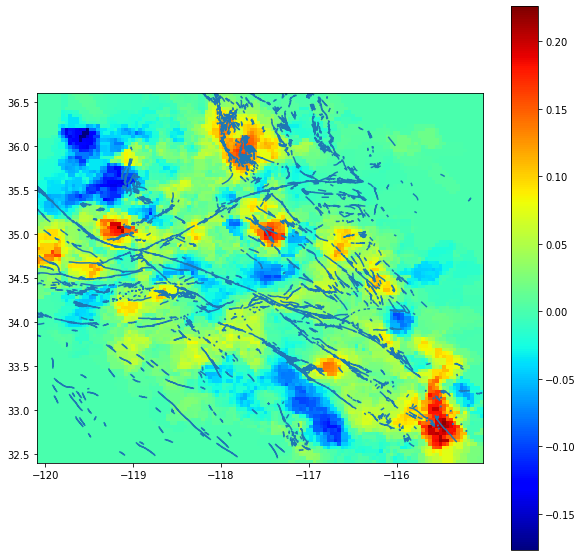

In [140]:
pdfault = pd.read_csv('../VoroTomo_src/SoCal_tomo/figures/cal_faults.dat',delim_whitespace=True,names=('lon','lat'))
plt.figure(figsize=(10,10))
plt.imshow(vel3d[2,:,:].T,cmap='jet',extent=(lonmin,lonmax,latmax,latmin))
plt.gca().invert_yaxis()
plt.plot(pdfault['lon'],pdfault['lat'],'-')
plt.xlim([lonmin,lonmax])
plt.ylim([latmin,latmax])
plt.colorbar()

# irrelavent: for testing

In [132]:
pdfault = pd.read_csv('../VoroTomo_src/SoCal_tomo/figures/cal_faults.dat',delim_whitespace=True,names=('lon','lat'))

In [ ]:
def findrayidx(ray):
        idxt = 1
        colid = []
        for ii in range(len(ray)):
            xpts = ray.iloc[ii]['rho']*np.sin(ray.iloc[ii]['theta'])*np.cos(ray.iloc[ii]['phi'])
            ypts = ray.iloc[ii]['rho']*np.sin(ray.iloc[ii]['theta'])*np.sin(ray.iloc[ii]['phi'])
            zpts = ray.iloc[ii]['rho']*np.cos(ray.iloc[ii]['theta'])
#             idx = int(idxt*np.sign(ii)) 
            idx = 0
            findpts = nearcells[idx]-1
            dis = (xpts-cellpos[findpts,0])**2+(ypts-cellpos[findpts,1])**2+\
                    (hvratio*(zpts-cellpos[findpts,2]))**2
            midx = np.argmin(dis)
            colid.append(findpts[midx])
            idxt = nearcells[idx][midx]
#             rowid[gpidx] = gpidx
#             gpidx += 1
        return colid
    

In [110]:
def outputproj():
    hvratio = 1.0
    cellpos, nearcells = voronoicells(latmin=latmin,latmax=latmax,lonmin=lonmin,\
            lonmax=lonmax, depmin=depmin,depmax=depmax, ncell = ncell)
    mdim = (nlat+1)*(nlon+1)*(nrad+1)
    latgrid = np.linspace(latmin,latmax,nlat+1)
    longrid = np.linspace(lonmin,lonmax,nlon+1)
    depgrid = np.linspace(depmin,depmax,nrad+1)

    latgrid = np.pi/2-np.deg2rad(latgrid)
    longrid = np.deg2rad(longrid)
    depgrid = 6371.0-depgrid

    colid = np.zeros(mdim,dtype=int)
    rowid = np.zeros(mdim,dtype=int)

    idxt = 1
    gpidx = 0
    for kk in range(nrad+1):
        for jj in range(nlon+1):
            for ii in range(nlat+1):
                xpts = depgrid[kk]*np.sin(latgrid[ii])*np.cos(longrid[jj])
                ypts = depgrid[kk]*np.sin(latgrid[ii])*np.sin(longrid[jj])
                zpts = depgrid[kk]*np.cos(latgrid[ii])
    #             idx = int(idxt*np.sign(ii)) 
                idx = 0
                findpts = nearcells[idx]-1
                dis = (xpts-cellpos[findpts,0])**2+(ypts-cellpos[findpts,1])**2+\
                        (hvratio*(zpts-cellpos[findpts,2]))**2
                midx = np.argmin(dis)
                colid[gpidx] = findpts[midx]
                idxt = nearcells[idx][midx]
                rowid[gpidx] = gpidx
                gpidx += 1
    Gp = coo_matrix((np.ones(mdim,),(rowid,colid)),shape=(mdim,ncell))
    return cellpos,nearcells,Gp

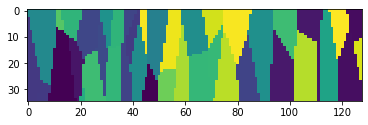

In [177]:
dws = Gp*np.arange(ncell)
dws3d = dws.reshape(nrad+1,nlon+1,nlat+1)
plt.imshow(dws3d[:,:,2])